# Analyze Ceramide Staining Intensity

### Import Modules

In [1]:
# Import packages
import datetime
import os
import glob
import pandas as pd
import numpy as np

# Import plotting packages
import matplotlib as mpl
import seaborn as sns
import dabest

print("matplotlib v{}".format(mpl.__version__))
print("seaborn v{}".format(sns.__version__))
print("dabest v{}".format(dabest.__version__))

We're using DABEST v0.2.4


/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Add experiment date here to apply to dataframe
now = datetime.datetime.now()
analysis_date = now.strftime("%Y%m%d")

path = os.path.abspath('')+'/CSVs/'
full_df = pd.DataFrame()
list_ = []

# For loop to bring in files and concatenate them into a single dataframe


for file_ in glob.glob(path + "/*.csv"):
    df = pd.read_csv(file_)
    # Determine Image name from file name
    df['Image'] = os.path.splitext(os.path.basename(file_))[0]
    # Split values in ROI label
    df['Fluor'], df['ROI'] = zip(*df['Label'].map(lambda x: x.split(':')))
    # Split values in Image name column
    (df['ExptDate'], df['Treatment'], df['Stains'], df['Embryo'], 
        df['Somites'], df['Section']) = zip(*df['Image'].map(lambda x: x.split('_')))
    
    # Replace background ROI names
        # NOTE: I have updated the Fiji macro ('FluorIntensity_2Channel.ijm') to name all background ROIs as 'background',
        # so this step will be unnecessary with freshly collected data
    #df.replace(to_replace=['back1a', 'back1b', 'back1c', 'back2a', 'back2b', 'back2c'],
     #                       value=['background', 'background', 'background', 'background', 'background', 'background'], 
      #                      inplace=True)
    list_.append(df)

full_df = pd.concat(list_)
full_df.head()

,,Label,Area,Mean,Min,Max,IntDen,RawIntDen,Image,Fluor,ROI,ExptDate,Treatment,Stains,Embryo,Somites,Section
0,1,Ceramide:background,13.758,23.903,10,45,328.858,6382.0,"20190322_SMPD3MO0,8mM_Pax7TCFLefRFPGFPCeramide...",Ceramide,background,20190322,"SMPD3MO0,8mM",Pax7TCFLefRFPGFPCeramide,Emb7,8ss,sec1
1,2,Ceramide:background,12.882,24.100,11,45,310.462,6025.0,"20190322_SMPD3MO0,8mM_Pax7TCFLefRFPGFPCeramide...",Ceramide,background,20190322,"SMPD3MO0,8mM",Pax7TCFLefRFPGFPCeramide,Emb7,8ss,sec1
2,3,Ceramide:background,12.315,24.427,12,47,300.826,5838.0,"20190322_SMPD3MO0,8mM_Pax7TCFLefRFPGFPCeramide...",Ceramide,background,20190322,"SMPD3MO0,8mM",Pax7TCFLefRFPGFPCeramide,Emb7,8ss,sec1
3,4,Ceramide:Cntl,2951.014,85.652,7,364,252761.184,4905222.0,"20190322_SMPD3MO0,8mM_Pax7TCFLefRFPGFPCeramide...",Ceramide,Cntl,20190322,"SMPD3MO0,8mM",Pax7TCFLefRFPGFPCeramide,Emb7,8ss,sec1
4,5,Ceramide:Expt,2184.211,79.073,11,292,172712.326,3351750.0,"20190322_SMPD3MO0,8mM_Pax7TCFLefRFPGFPCeramide...",Ceramide,Expt,20190322,"SMPD3MO0,8mM",Pax7TCFLefRFPGFPCeramide,Emb7,8ss,sec1


In [3]:
# Get a list of treatments
treatment_list = full_df.Treatment.unique()
treatment_list = treatment_list.tolist()

# Mean background values and group by Treatment, Embryo, Fluor, ROI and Section
mean_sections = ((full_df.groupby(['Treatment', 'Embryo', 'Fluor', 'ROI', 'Section', 'ExptDate'])
                  ['Area', 'Mean', 'IntDen']).mean())

# Loop trough treatments, performing each analysis and exporting CSV file for each treatment
for i in treatment_list:
    # Slice dataframe to process only embryos with given treatment
    treatment = i
    df_treatment = pd.DataFrame(mean_sections.xs(treatment))

    # Determine CTCF values = ROI IntDen - (background mean * ROI area)
    # Calculate background (background mean * ROI area)
    background_corr_cntl = (df_treatment.xs('background', level='ROI')['Mean'] 
                    * df_treatment.xs('Cntl', level='ROI')['Area'])
    background_corr_expt = (df_treatment.xs('background', level='ROI')['Mean'] 
                    * df_treatment.xs('Expt', level='ROI')['Area'])

    # Slice out only Cntl or Expt values in IntDen
    intdens_cntl = df_treatment.xs('Cntl', level='ROI')['IntDen'] 
    intdens_expt = df_treatment.xs('Expt', level='ROI')['IntDen'] 

    # Subtract background from IntDens to determine CTCF and concatenate into single dataframe
    sub_cntl = pd.DataFrame(intdens_cntl - background_corr_cntl)
    sub_expt = pd.DataFrame(intdens_expt - background_corr_expt)
    full_ctcf = pd.concat([sub_cntl, sub_expt], keys = ['Cntl', 'Expt'])
    full_ctcf.columns = ['CTCF']

    # Pull out TCFLef and H2BRFP values
    ctcf_tcflef = full_ctcf.xs('TCFLefd2eGFP', level='Fluor')['CTCF'] 
    ctcf_RFP = full_ctcf.xs('H2BRFP', level='Fluor')['CTCF'] 

    # Normalize for electroporation efficiency by determining TCFLef/RFP
    electroporation_norm = pd.DataFrame(ctcf_tcflef / ctcf_RFP)
    electroporation_norm.columns = ['CTCF']
    electroporation_norm.index.names = ['Side', 'Embryo', 'Section', 'ExptDate']

    # Average sections grouped by embryos before generating Expt/Cntl ratio
    averaged_sections = electroporation_norm.groupby(['Side','Embryo', 'ExptDate']).mean()

    # Pull out Cntl and Expt CTCFs
    ctcf_cntl = averaged_sections.xs('Cntl', level='Side')['CTCF'] 
    ctcf_expt = averaged_sections.xs('Expt', level='Side')['CTCF'] 

    # Generate ratios as Expt/Cntl
    ratios_sections = pd.DataFrame(ctcf_expt / ctcf_cntl)
    ratios_sections.columns = ['Expt/Cntl CTCF']

    # Normalize individual values to mean of control group
    norm_cntl = ctcf_cntl/(float(ctcf_cntl.mean()))
    norm_cntl = pd.DataFrame(norm_cntl)
    norm_cntl.columns = ['Control MO']
    norm_expt = ctcf_expt/(float(ctcf_cntl.mean()))
    norm_expt = pd.DataFrame(norm_expt)
    norm_expt.columns = ['nSMase2 MO']

    # Combine processed values into single dataframe and output as csv file 'Results.csv'
    ctcf_cntl = pd.DataFrame(ctcf_cntl)
    ctcf_cntl.columns = ['Cntl CTCF']
    ctcf_expt = pd.DataFrame(ctcf_expt)
    ctcf_expt.columns = ['Expt CTCF']
    results = (pd.concat([ctcf_cntl, ctcf_expt, ratios_sections, norm_cntl, norm_expt], axis=1, sort=True)).reset_index()
    results['ID'] = results.ExptDate.str.cat(results.Embryo)
    results.to_csv(analysis_date + '_' + treatment + '_CTCFResults_6ss.csv')
    
results

,Embryo,ExptDate,Cntl CTCF,Expt CTCF,Expt/Cntl CTCF,Control MO,nSMase2 MO,ID
0,Emb1,20190507,0.504482,0.402890,0.798621,1.362822,1.088378,20190507Emb1
1,Emb1,20190520,0.347855,0.342775,0.985395,0.939705,0.925981,20190520Emb1
2,Emb2,20190507,0.424278,0.370846,0.874064,1.146156,1.001813,20190507Emb2
3,Emb2,20190520,0.227935,0.264035,1.158379,0.615750,0.713272,20190520Emb2
4,Emb3,20190520,0.259482,0.218803,0.843232,0.700970,0.591081,20190520Emb3
5,Emb4,20190507,0.349414,0.256744,0.734786,0.943915,0.693575,20190507Emb4
6,Emb5,20190507,0.382568,0.249589,0.652404,1.033479,0.674246,20190507Emb5
7,Emb5,20190520,0.563473,0.368758,0.654437,1.522182,0.996171,20190520Emb5
8,Emb6,20190507,0.272086,0.173058,0.636040,0.735021,0.467503,20190507Emb6


**Plotting and Statistical Analysis using DABEST**

In [4]:
results_6ss = pd.read_csv('20190608_SMPD3MO0,8mM_CTCFResults_6ss.csv')
results_6ss.head()

,Unnamed: 0,Embryo,ExptDate,Cntl CTCF,Expt CTCF,Expt/Cntl CTCF,Control MO,nSMase2 MO,ID
0,0,Emb1,20190507,0.504482,0.402890,0.798621,1.362822,1.088378,20190507Emb1
1,1,Emb1,20190520,0.347855,0.342775,0.985395,0.939705,0.925981,20190520Emb1
2,2,Emb2,20190507,0.424278,0.370846,0.874064,1.146156,1.001813,20190507Emb2
3,3,Emb2,20190520,0.227935,0.264035,1.158379,0.615750,0.713272,20190520Emb2
4,4,Emb3,20190520,0.259482,0.218803,0.843232,0.700970,0.591081,20190520Emb3


In [5]:
results = dabest.load(results_6ss, idx=('Control MO', 'nSMase2 MO')
                                ,id_col='ID', paired=True)
results.mean_diff.statistical_tests

/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


,control,test,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Control MO,nSMase2 MO,mean difference,True,-0.205331,95,-0.43838,0.013658,0.015156,2.0,0.01083,3.30176


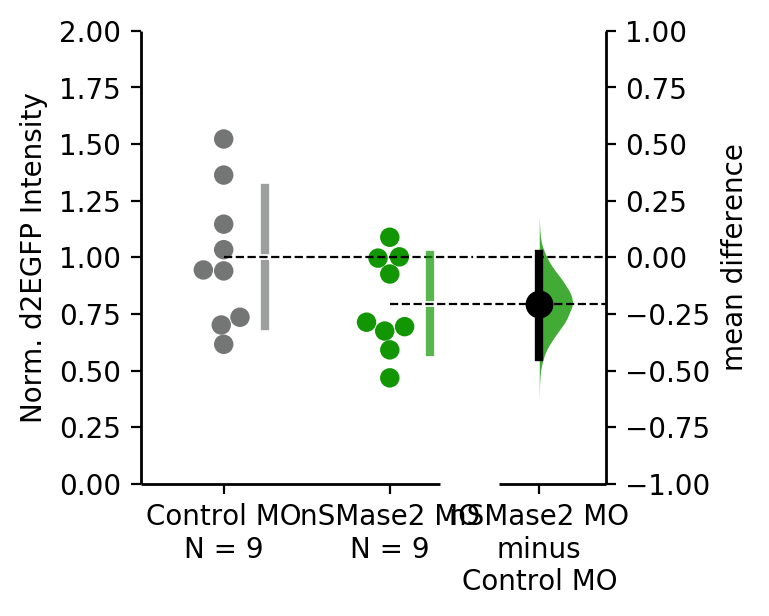

In [6]:


fig1 = results.mean_diff.plot(
    #Set overall figure parameters
                dpi=200
                ,fig_size=(3,3)
    
    #Edit legend features, use matplotlib.Axes.legend kwargs in dictionary format
#                 ,legend_kwargs={'loc':'upper left'
#                                 ,'frameon':True}

    
    #Edit 0 line features, use matplotlib.Axes.hlines kwargs in dictionary format
                ,reflines_kwargs= {'linestyle':'dashed'      
                               ,'linewidth':.8
                               ,'color' : 'black'}
    
    #Set swarm plot parameters    
                ,swarm_label='Norm. d2EGFP Intensity'
                ,swarm_ylim=(0,2)
                ,show_pairs=False                    #connect paired points? Yes (True), no (False)
#                 ,color_col='ID'                   #color points based on defined column identifier
                ,custom_palette={'Control MO':'#747575'
                                 ,'nSMase2 MO':'#139604'}
                ,swarm_desat=1
                ,group_summaries='mean_sd'           #display mean+/-sd as bars next to swarm plots
                ,group_summaries_offset=0.15
    #Edit swarmplot features, use seaborn.swarmplot kwargs in dictionary format
                ,swarmplot_kwargs={'size':7}

    
    #Edit group summary line features, use matplotlib.lines.Line2D kwargs in dictionary format
                ,group_summary_kwargs={'lw':3
                                      ,'alpha':.7}
    #Set effect size plot parameters
                ,float_contrast=True                 #displays mean difference next to graph (True) or below graph (False)
                ,contrast_label='mean difference'
                ,es_marker_size=9 
                ,halfviolin_desat=1
                ,halfviolin_alpha=0.8
    #Edit violin features, use sns.violinplot kwargs in dictionary format
                ,violinplot_kwargs={'widths':0.5}
    
    #Edit legend features, use matplotlib.Axes.legend kwargs in dictionary format
#                 ,legend_kwargs={'loc':'upper left'
#                                 ,'frameon':True}


    #Edit slopegraph features, use 
                    #kwargs in dictionary format
#                 ,slopegraph_kwargs={'color':'blue'}
                             )

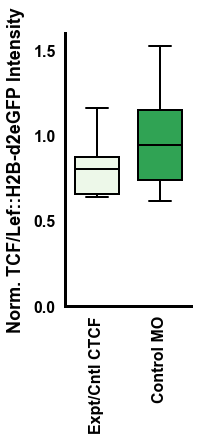

In [9]:
# Build our plot of these data

# first, define figure size and style
plt.figure(figsize=(3,6))
sns.set(style='white'
        ,rc={'font.family':'sans-serif'
             ,'axes.edgecolor':'black'
            }
       )
            
# customize style and text on each axis
plt.xticks(size=16
           ,weight='bold'
           ,color='black'
           ,rotation='vertical')
plt.ylim(0,1.6)
plt.yticks([0, 0.5, 1, 1.5]
           ,size=16
           ,weight='bold'
           ,color='black'
          )
plt.ylabel('Norm. TCF/Lef::H2B-d2eGFP Intensity'
           ,size=18
           ,weight='bold'
           ,color='black'
           ,labelpad=8
          )

# make color palate to label each dataset
# add more colors if using more datasets
my_pal = ('#EDF8E9','#30A354')

# finally, make the boxplot
myplot = sns.boxplot(data=results_6ss.iloc[:,5:7]
                     ,palette=my_pal
                     ,saturation=1
                     ,width=0.7
                     ,boxprops = {'edgecolor': 'black', 'linewidth': 2}
                     ,whiskerprops = {'color': 'black', 'linewidth':2}
                     ,medianprops = {'color': 'black', 'linewidth':2}
                     ,capprops = {'color': 'black', 'linewidth':2}
                )

# use this segment if you want to add a jitterplot overtop of the box plot
# myplot = sns.swarmplot(data=results.iloc[:,5:7], 
#               color='#252525',
#               size=8)

# adjust the axes around the box: despine to remove the top and right line, then for loop to update the x- and y-axis
sns.despine()
for axis in ['top','bottom','left','right']:
    myplot.spines[axis].set_linewidth(3)
    
# tighten the figure boundaries to the graph
plt.tight_layout()

In [15]:
# Get descriptive statistics
mean = results_6ss.mean()
sem = results_6ss.sem()
corr = results_6ss.corr()
print(mean)
print(sem)
print(corr)

# Perform two-tailed paired ttest from results
ttest = stats.ttest_rel(results_6ss['Control MO'], results_6ss['nSMase2 MO'])
print(ttest)

Unnamed: 0        4.000000e+00
ExptDate          2.019051e+07
Cntl CTCF         3.701749e-01
Expt CTCF         2.941665e-01
Expt/Cntl CTCF    8.152619e-01
Control MO        1.000000e+00
nSMase2 MO        7.946689e-01
dtype: float64
Unnamed: 0        0.912871
ExptDate          2.283867
Cntl CTCF         0.037550
Expt CTCF         0.026423
Expt/Cntl CTCF    0.057996
Control MO        0.101438
nSMase2 MO        0.071381
dtype: float64
                Unnamed: 0  ExptDate  Cntl CTCF  Expt CTCF  Expt/Cntl CTCF  \
Unnamed: 0        1.000000 -0.086603  -0.099136  -0.628305       -0.658495   
ExptDate         -0.086603  1.000000  -0.172545   0.052973        0.518532   
Cntl CTCF        -0.099136 -0.172545   1.000000   0.795328       -0.437552   
Expt CTCF        -0.628305  0.052973   0.795328   1.000000        0.167703   
Expt/Cntl CTCF   -0.658495  0.518532  -0.437552   0.167703        1.000000   
Control MO       -0.099136 -0.172545   1.000000   0.795328       -0.437552   
nSMase2 MO       -

In [13]:
results_6ss.head()

,Unnamed: 0,Embryo,ExptDate,Cntl CTCF,Expt CTCF,Expt/Cntl CTCF,Control MO,nSMase2 MO,ID
0,0,Emb1,20190507,0.504482,0.402890,0.798621,1.362822,1.088378,20190507Emb1
1,1,Emb1,20190520,0.347855,0.342775,0.985395,0.939705,0.925981,20190520Emb1
2,2,Emb2,20190507,0.424278,0.370846,0.874064,1.146156,1.001813,20190507Emb2
3,3,Emb2,20190520,0.227935,0.264035,1.158379,0.615750,0.713272,20190520Emb2
4,4,Emb3,20190520,0.259482,0.218803,0.843232,0.700970,0.591081,20190520Emb3


In [17]:
len(results_6ss['Embryo'])

9